# DSCI100: Group31 Project Report
### Members
- Arshdeep Jassi
- Cassiel Jung
- Divya Gupta
- Lily Zhang

## 1.0 Introduction
Athletes put enormous efforts to shape their body to fit the sports they are playing to improve their performance. Marathon runners tend to be light and lean while top footballers have stronger lower body muscles. Even within top swimmers, they tend to develop different muscles in upper body. While researching for the group project topic our team got curious about whether there is a certain preferred physique for tennis too. Thus, throughout this project, we are going to answer the question **“What is the relationship between the physique of tennis players and their probability of winning?”**.  
  
To answer the question, the dataset **‘Game results for Top 500 Players from 2017-2019’** will be used. It contains the data of each tennis game played by Top 500 Players in between 2017 and 2019. Each row corresponds to a game and it includes information of both the winner and loser of the game such as their height, age, and dominant hand. Since the dataset contains 3 years of data and we want to see if age is related to the winning probability, we will calculate the probability of winning of each player for each year based on their age.  
  
Our response variable, probability of winning, is a numeric type between 0 and 1. Therefore, we are going to use the **regression model** provided by tidymodels library in R. At this point we are not sure which regression model would predict better. To see the difference between knn and linear regression model, we are going to test with both to compare their accuracy and use the most suitable model to answer our question.

## 2.0 Method & Results
Libraries to use:
1. tidyverse: to use read_csv/ggplot and many other basic data analysis functions
2. repre: to represent string/binary variables
3. tidymodels: to use regression model later

In [45]:
# Load required libraies for analysis
library(tidyverse)
library(repr)
library(tidymodels)

### 2.1 Loads data
We take the dataset from the google drive using read_csv() function and url.

In [46]:
tennis_raw_data <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(tennis_raw_data)

Warning message:
“Missing column names filled in: 'X1' [1]”
Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)

See spec(...) for full column specifications.



X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


Table 1: The raw data of tennis games

### 2.2 Clean and Wrangling the dataset

Since we cannot treat players who played 2 games and won both and players who played 100 games and won 2 as the same, we decided to calculate the proportion of won games.

We followed the steps below to clean the data and calculate the probability of winning:
1. Round up winner_age to whole number with function round() to calculate probability of winning in **each year**
2. **Get winner's height, dominant hand and number of wins** in each year using group_by() and summarise() functions.
3. **Remove duplicates** using the unique() function.
4. Repeat step 1 to 4 for loser_data
5. **Bind winner_data and loser_data** then calculate the probability of winning to have the format *[player_id, age, height, hand, num_winning, num_losing, num_games, prob_winning]*
6. Convert dominant hand of players into numeric value; 1 for right-handed, 0 for left-handed
7. Filter players who played less than 8 games
  
*Step 7 was added later to increase accuracy of model*


In [47]:
# Get number of game won for each player per year
winner_data <- tennis_raw_data %>%
                mutate(age = round(winner_age, digit = 0)) %>%
                group_by(winner_id, age) %>%
                summarise(height = winner_ht, hand = winner_hand, num_winning = n()) %>%
                rename(player_id = winner_id) %>%
                unique()

# Get number of game lost for each player per year
loser_data <- tennis_raw_data %>%
                mutate(age = round(loser_age, digit = 0)) %>%
                group_by(loser_id, age) %>%
                summarise(height = loser_ht, hand = loser_hand, num_losing = n()) %>%
                rename(player_id = loser_id) %>%
                unique()

# Bind winner_data and loser_data then calculate probability of winning
tennis_clean <- bind_rows(winner_data, loser_data) %>%
                as_tibble() %>%
                replace_na(list(num_winning = 0, num_losing = 0)) %>%
                group_by(player_id, age) %>%
                summarize(height = height, 
                          hand = hand, 
                          num_winning = sum(num_winning), 
                          num_losing = sum(num_losing),
                          num_games = num_winning + num_losing,
                          prob_winning = (num_winning / num_games)) %>%
                unique() %>%
                filter(num_games >= 8) %>%
                mutate(hand = case_when(hand == "L" ~ 0, hand == "R" ~ 1)) %>%
                as_tibble()

# To remove players with NA
tennis_clean <- tennis_clean[complete.cases(tennis_clean),]

head(tennis_clean)

`summarise()` regrouping output by 'winner_id', 'age' (override with `.groups` argument)

`summarise()` regrouping output by 'loser_id', 'age' (override with `.groups` argument)

`summarise()` regrouping output by 'player_id', 'age' (override with `.groups` argument)



player_id,age,height,hand,num_winning,num_losing,num_games,prob_winning
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
100644,20,198,1,45,16,61,0.7377049
100644,21,198,1,48,19,67,0.7164179
100644,22,198,1,42,22,64,0.6562500
103333,38,208,1,11,13,24,0.4583333
103333,39,208,1,10,19,29,0.3448276
103333,40,208,1,10,13,23,0.4347826


Table 2: Cleaned tennis data with columns related to the analysis

### 2.3 Splitting dataset
To make sure our model does not see data that it would be tested on, we split dataset into two: 75% for train and 25% for test

In [48]:
set.seed(42) 
tennis_split <- initial_split(tennis_clean, prop = 0.75)  
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

### 2.4 Summarize data
#### 2.4.1 Summarize quantitative variables
One of the metrics that can be explored is the average values of the quantitative variables we are considering in the analysis such as height and age. We will calculate average height of players whose probability of winning is over 50% and less than 50%. As you can see from below, the difference in average height or age was really small between players who won more and who lost more. If we compare up to decimal places, we are able to check that taller and younger players won more.

In [49]:
tennis_avg <- tennis_clean %>%
              mutate(player_type = as.factor(case_when(prob_winning >= 0.5 ~ "More Winning", prob_winning < 0.5 ~ "More Losing"))) %>%
              group_by(player_type) %>%
              summarize(avg_height = mean(height, na.rm = TRUE),
                        avg_age = mean(age, na.rm = TRUE))

tennis_avg

`summarise()` ungrouping output (override with `.groups` argument)



player_type,avg_height,avg_age
<fct>,<dbl>,<dbl>
More Losing,186.0889,30.59259
More Winning,186.6985,29.67647


Table 3: Average height and age of players that are winning more and losing more respectively

#### 2.4.2 Summarize categorical variable
There is one more variable we are considering for the analysis which is handedness of the players. Since it is a categorical variable, we counted number of lefthanded and righthanded players whose probability of winning is over 50%. Then, we calculated percentage of left-handed palyers. To check the difference with players whose probability of winning is less than 50%, we repeated the same process for them.

In [50]:
# Get number of lefthanded and righthanded players whose probability of winning is greater than equal to 0.5 and less than 0.5 separately
tennis_hand <- tennis_clean %>%
                mutate(player_type = as.factor(case_when(prob_winning >= 0.5 ~ "More Winning", prob_winning < 0.5 ~ "More Losing"))) %>%
                group_by(player_type) %>%
                mutate(handedness = as.factor(case_when(hand == 0 ~ "left", hand == 1 ~ "right"))) %>%
                count(handedness) %>%
                pivot_wider(names_from = handedness, values_from = n) %>%
                mutate(prob_left = left / (left + right))

tennis_hand

player_type,left,right,prob_left
<fct>,<int>,<int>,<dbl>
More Losing,23,112,0.1703704
More Winning,17,119,0.1250000


Table 4: Number of lefthanded and righthanded players with more winnings and more losings respectively, and percentage of lefthanded people

After the previous summarization of dominant hand, we wanted to compare the probability of winning of left-handed players and right-handed players. Therefore, we found the average probability of winning for left-handed players and right-handed players. The average probability of winning for right-handed players was slightly greater than that of left-handed players.

In [51]:
handedness_prob_winning <- tennis_clean %>%
                            mutate(handedness = case_when(hand == 0 ~ "left", hand == 1 ~ "right")) %>%
                            group_by(handedness) %>%
                            summarize(avg_prob_winning = mean(prob_winning, na.rm = TRUE))

handedness_prob_winning

`summarise()` ungrouping output (override with `.groups` argument)



handedness,avg_prob_winning
<chr>,<dbl>
left,0.4752377
right,0.4947288


Table 5: Average probability of winning for each handedness

### 2.5 Visualize summarized data

#### 2.5.1 Distribution of height of players
To compare the distribution of height of players depending on their probability of winning, we plotted *two bar graphs side by side* using the tennis_clean data. As we saw previously in section 2.4.1 their distribution seems quite similar. However, we can still check that the number of players with height in the range 190cm to 200cm is greater for players who have a winning probability greater than 0.5.

Warning message:
“position_stack requires non-overlapping x intervals”
Warning message:
“position_stack requires non-overlapping x intervals”


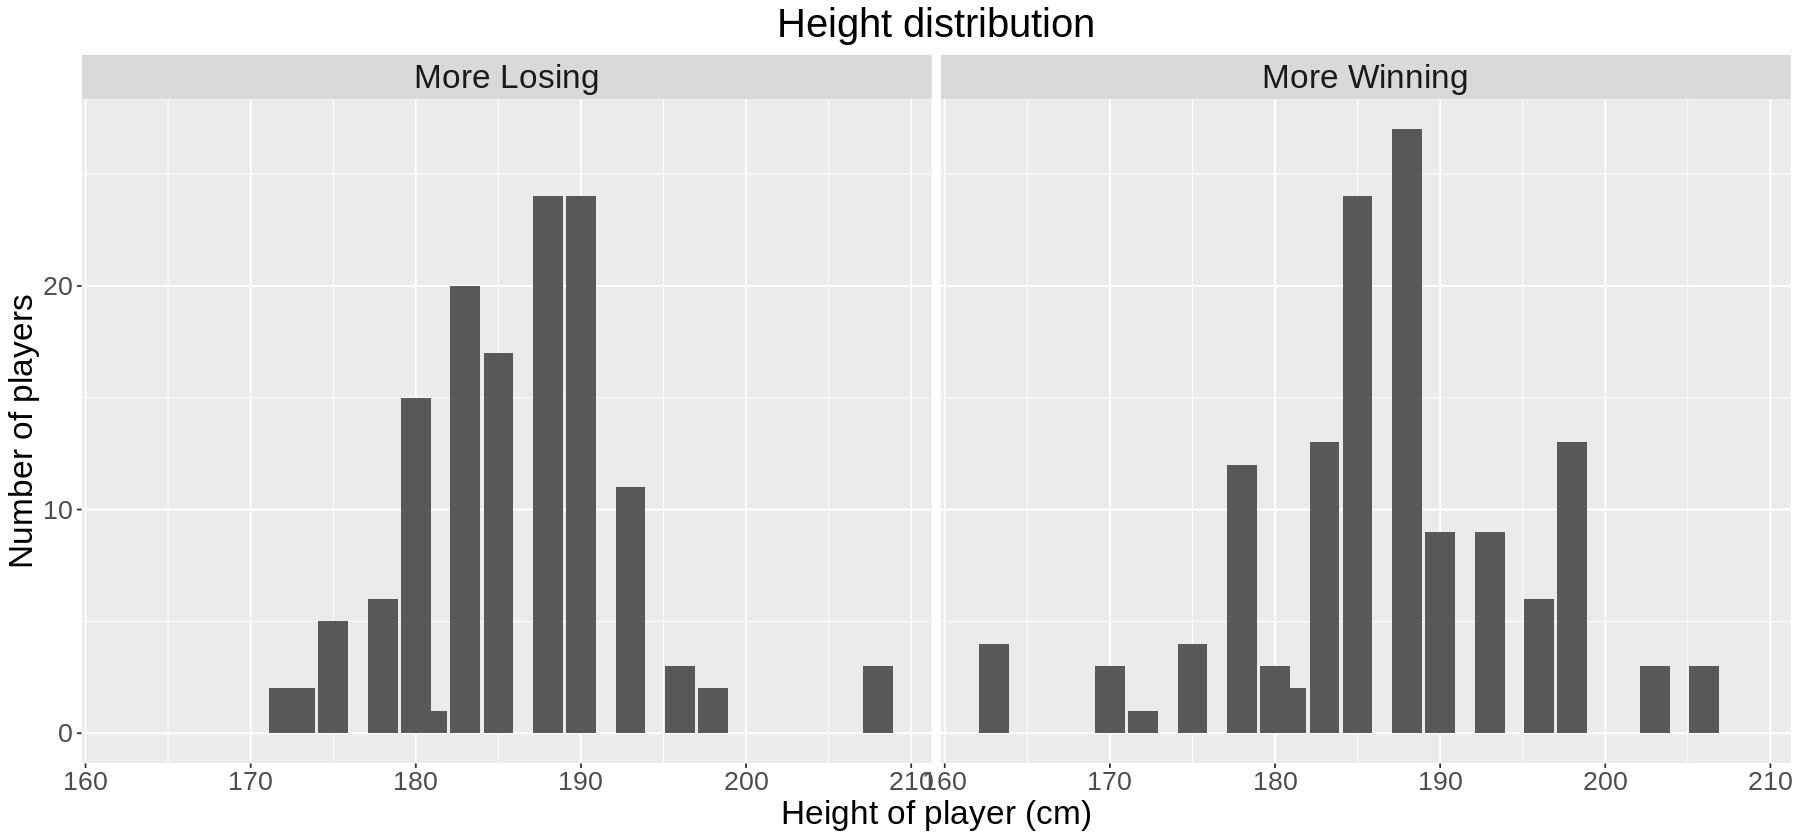

In [52]:
options(repr.plot.height = 7, repr.plot.width = 15)
height_plot <- tennis_clean %>%
                mutate(player_type = as.factor(case_when(prob_winning >= 0.5 ~ "More Winning",
                                                         prob_winning < 0.5 ~ "More Losing"))) %>%
                ggplot(aes(x = height)) +
                geom_bar(width = 1.8) +
                facet_grid(. ~ player_type) +
                labs(x = "Height of player (cm)", y = "Number of players") +
                ggtitle("Height distribution") +
                theme(text = element_text(size = 20),
                      plot.title = element_text(hjust = 0.5),
                      strip.text = element_text(size = 20))

height_plot

Figure 1: Height distribution of players that are winning more and losing more respectively

#### 2.5.3 Distribution of age of players
Similar to the comparing distribution of height of players, we plotted two side by side graphs based on a player's age and their probability of winning. Surprisingly, unlike the average calculation where the average age of players did not have much difference between two set of players (divided based on their winning probability), it is distinguishable that the age distribution of players with winning probability less than 0.5 is right-skewed while that of players who win the game more is left-skewed. From this graph, we can check that players who are younger have a greater probability of winning.

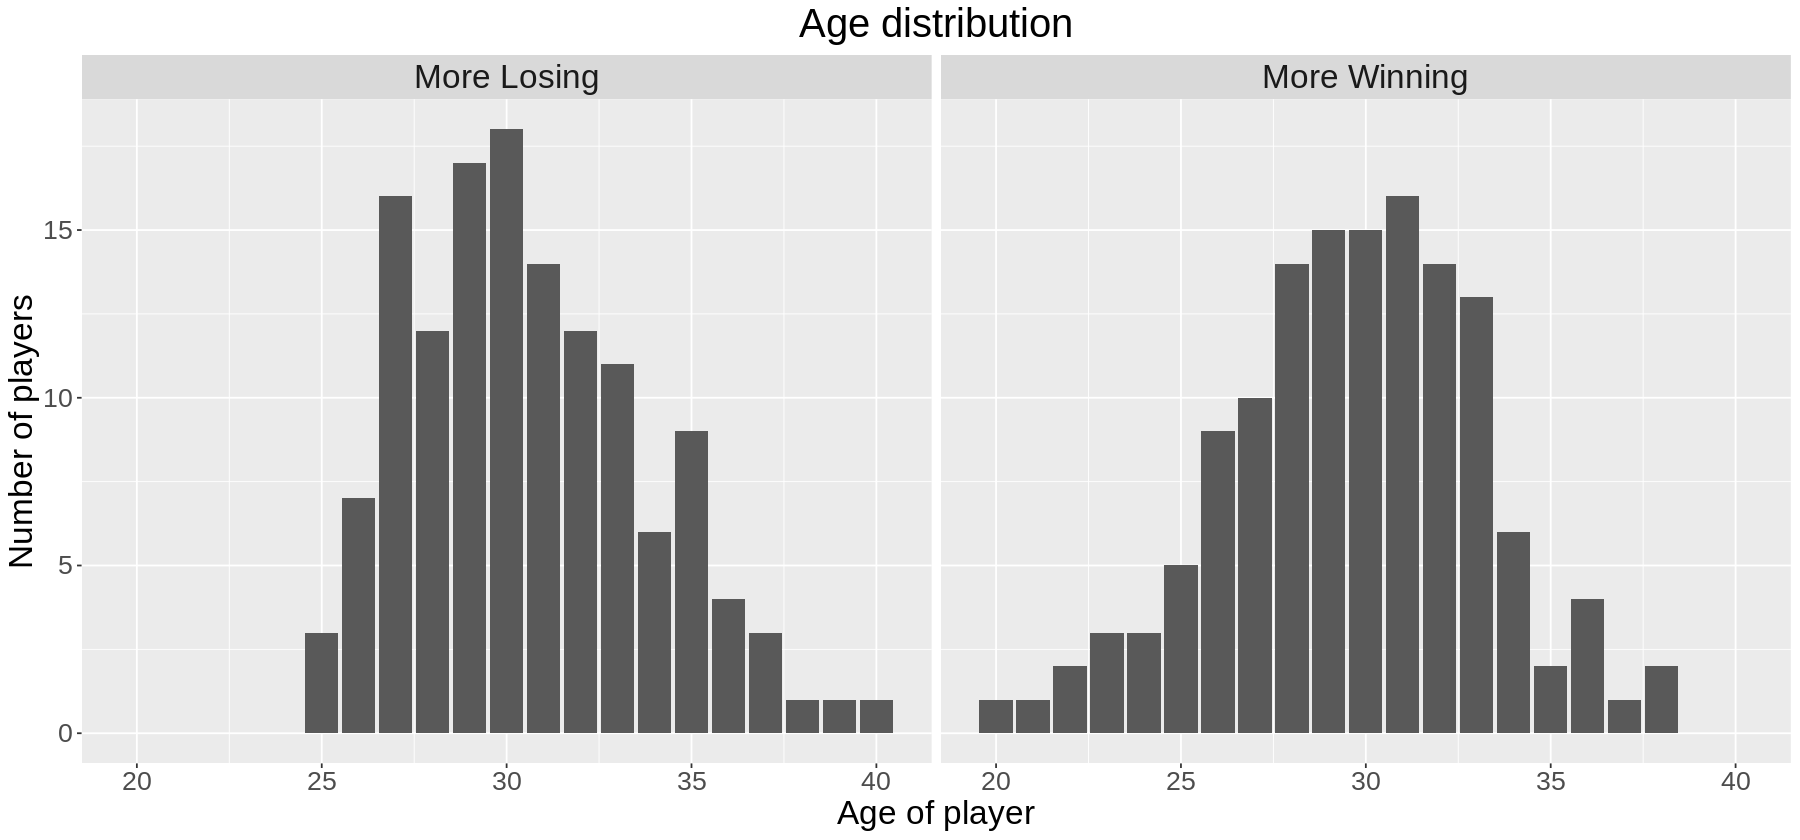

In [53]:
options(repr.plot.height = 7, repr.plot.width = 15)
age_plot <- tennis_clean %>%
            mutate(player_type = as.factor(case_when(prob_winning >= 0.5 ~ "More Winning",
                                                     prob_winning < 0.5 ~ "More Losing"))) %>%
            ggplot(aes(x = age)) +
            facet_grid(. ~ player_type) +
            geom_bar() +
            labs(x = "Age of player", y = "Number of players") +
            ggtitle("Age distribution") +
            theme(text = element_text(size = 20),
                      plot.title = element_text(hjust = 0.5),
                      strip.text = element_text(size = 20))
age_plot

Figure 2: Age distribution of players that are winning more and losing more respectively

#### 2.5.4 Distribution of dominant hand
Here we are going to visuallize tennis_hand data that we calculated at section 2.4.2.

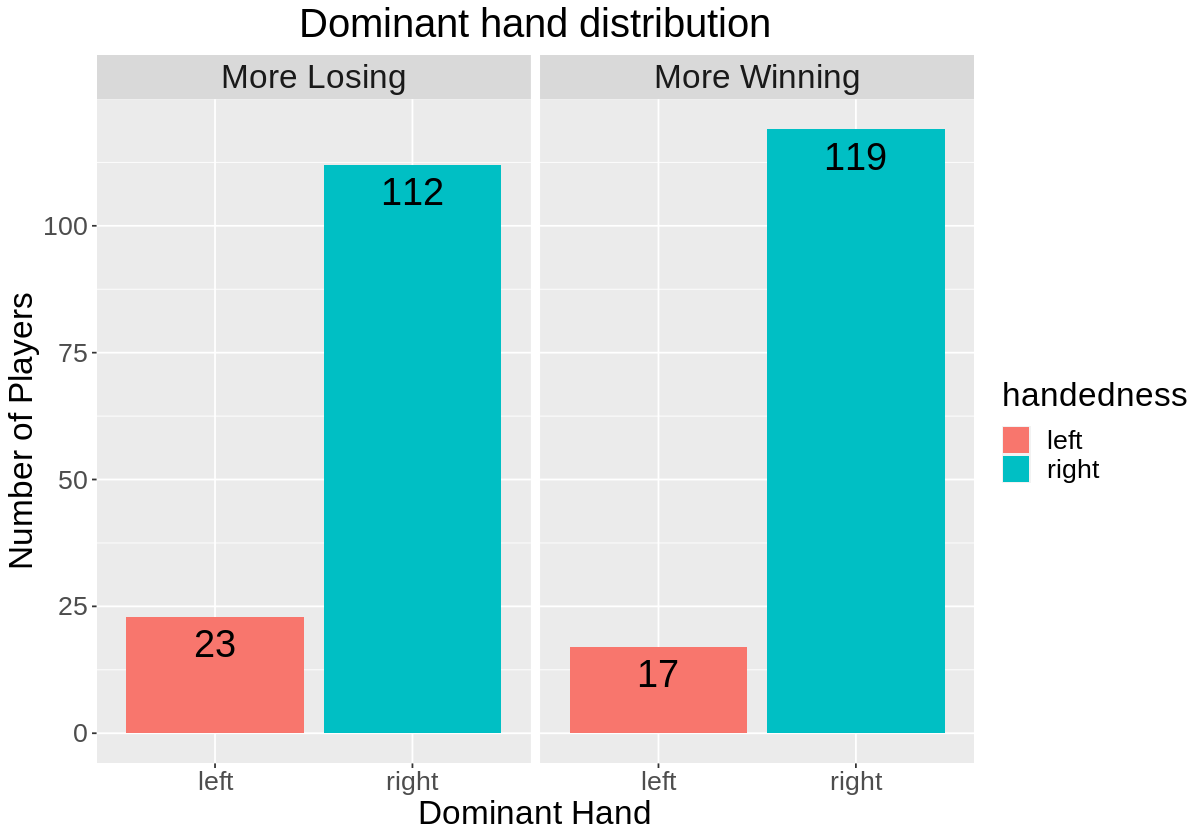

In [54]:
options(repr.plot.height = 7, repr.plot.width = 10)
hand_plot <- tennis_clean %>%
             mutate(player_type = as.factor(case_when(prob_winning >= 0.5 ~ "More Winning",
                                                         prob_winning < 0.5 ~ "More Losing")),
                    handedness = as.factor(case_when(hand == 0 ~ "left", hand == 1 ~ "right"))) %>%
             select(player_type, handedness) %>%
             table() %>%
             as_tibble() %>%
             group_by(player_type) %>%
             ggplot(aes(x = handedness, y = n, fill = handedness)) +
                geom_bar(stat = "identity") +
                geom_text(aes(label = n), size = 8, vjust = 1.5) +
                facet_grid(. ~ player_type) +
                labs(x = "Dominant Hand", y = "Number of Players", title = "Dominant hand distribution") +
                theme(text = element_text(size = 20),
                      plot.title = element_text(hjust = 0.5),
                      strip.text = element_text(size = 20))
                
hand_plot

Figure 3: Distribution of dominant hand of players that are winning more and losing more respectively

#### 2.5.5 Average probability of winning for each dominant hand
As we calculated average probability of winning for each handedness at the end of section 2.4.2, we are going to visuallize that as well.

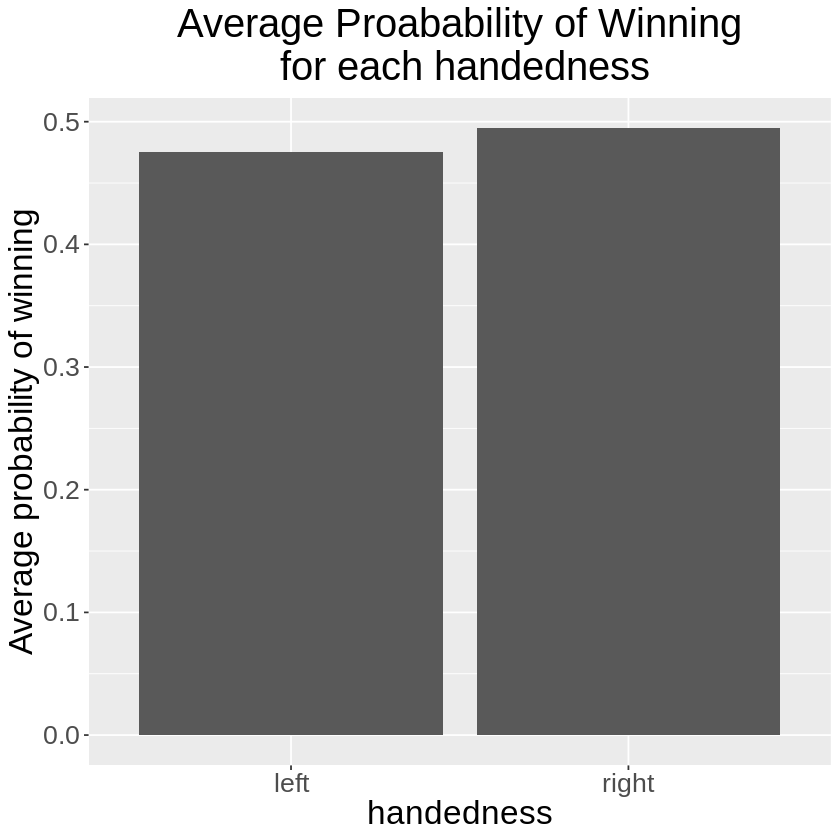

In [55]:
options(repr.plot.height = 7, repr.plot.width = 7)
hand_plot2 <- handedness_prob_winning %>%
                ggplot(aes(x = handedness, y = avg_prob_winning)) +
                geom_bar(stat = "identity") +
                labs(x = "handedness", y = "Average probability of winning", 
                     title = "Average Proabability of Winning\n for each handedness") +
                theme(text = element_text(size = 20),
                      plot.title = element_text(hjust = 0.5))
hand_plot2

Figure 4: Average probability of winning for each handedness

### 2.6 Data Analysis
As mentioned briefly in the introduction, we were not sure which regression model we should use to answer our question. Therefore, we decided to try both K-nearest neighbour and linear regression and pick the one with highest accuracy.

#### 2.6.1 KNN Regression

We will perform cross-validation on the training data by first creating a model for knn specifically for regression, and creating a recipe with height, age, and hand as predictors, and probability of winning as the response variable.

In [56]:
set.seed(1234)

# Model specification to get the best k
tennis_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>% 
                  set_engine("kknn") %>%
                  set_mode("regression") 

# Create recipe
tennis_recipe <- recipe(prob_winning ~ height + age + hand, data = tennis_train) %>%
                  step_scale(all_predictors()) %>%
                  step_center(all_predictors())

tennis_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Operations:

Scaling for all_predictors()
Centering for all_predictors()

Using the model and recipe created, we are able to perform cross-validation with 5 folds on the training data with the strata being the probability of winning.

In [57]:
set.seed(1234)
tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = prob_winning)
tennis_workflow <- workflow() %>%
                    add_recipe(tennis_recipe) %>%
                    add_model(tennis_spec)
tennis_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Now, we can use RMSE to find the best k value. First, we create a tibble of the number of neighbours from 1 to 100. Then, we tune the workflow to test all the numbers of neighbours from the tibble created, also resample using the cross-validation data set. Next, we collect the statistics and use filter to get the rows with RMSE.

In [58]:
set.seed(2019)
gridvals <- tibble(neighbors = seq(from = 1, to = 100))

tennis_results <- tennis_workflow %>%
                    tune_grid(resamples = tennis_vfold, grid = gridvals) %>%
                    collect_metrics() %>%
                    filter(.metric == "rmse")
            
head(tennis_results)

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,0.1987991,5,0.009364086,Model001
2,rmse,standard,0.1587371,5,0.004636290,Model002
3,rmse,standard,0.1543543,5,0.004559845,Model003
4,rmse,standard,0.1533270,5,0.005021499,Model004
5,rmse,standard,0.1530499,5,0.006860417,Model005
6,rmse,standard,0.1531277,5,0.008881364,Model006


Table 6: RMSE values for all tested k-values in the cross validation

We will visualize the result of this by creating a line graph that compares the RMSE to each of the number of neighbours.

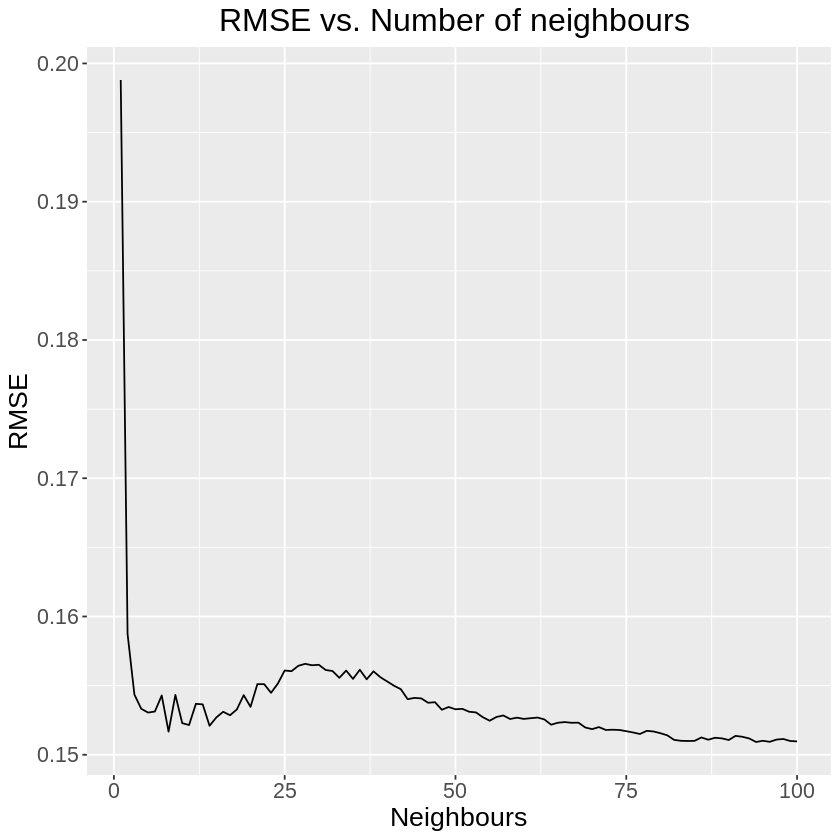

In [59]:
# visualize the change RMSPE for each neighbours
tennis_results_plot <- ggplot(tennis_results, aes(x = neighbors, y = mean)) +
                        geom_line() +
                        xlab("Neighbours") +
                        ylab("RMSE") + 
                        ggtitle("RMSE vs. Number of neighbours ") + 
                        theme(text = element_text(size = 16),
                               plot.title = element_text(hjust = 0.5))
                        
tennis_results_plot

Figure 5: Plot of RMSE values of k-neighbours from the cross validation

From the results of RMSE, we are generally looking for the neighbour with the lowest RMSE, so we arrange them from smallest to greatest and get the first row which would be the lowest RMSE.

In [60]:
set.seed(2020)

# Get the result
tennis_min <- tennis_results %>%
               arrange(mean) %>% 
               slice(1)

tennis_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
94,rmse,standard,0.1509237,5,0.006639385,Model094


Table 7: Minimum RMSE observation obtained through the cross validation

Although the RMSE is the lowest when there are 94 neighbours, it is actually underfitting, so in this case we chose k = 13 by looking at the line graph where the RMSE is low but at the same time it is not underfitting or overfitting.

Repeating the workflow analysis with the new k value. Now, we can make predictions on the testing data using the model we just created and use metrics to get the summary of the quality of this regression.

In [61]:
set.seed(1234)

# Create model specification with best k chosen
tennis_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) %>%
         set_engine("kknn") %>%
         set_mode("regression")

# Fit model with tennis_train
tennis_best_fit <- workflow() %>%
         add_recipe(tennis_recipe) %>%
         add_model(tennis_best_spec) %>%
         fit(data = tennis_train)

# Test model with tennis_test
tennis_summary <- tennis_best_fit %>%
          predict(tennis_test) %>%
          bind_cols(tennis_test) %>%
          metrics(truth = prob_winning, estimate = .pred)

tennis_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1442991
rsq,standard,0.1200362
mae,standard,0.1088146


Table 8: Metrics such as RMSPE obtained through applying the trained knn regression model on the test data

As seen in Table 8, the RMSPE is 0.1443. This means that the knn regression model prediction was roughly 14.43% away from the actual winning probability of any given tennis player on average.

Finally, we use the ggplot function to visualize the model's prediction by creating two different graphs that compares height and age respectively to the probability of winning, and visualize the difference of hands by using different colours. The predictions by the model are in blue lines on top of the training data points. It is not the best to visualize the 3 predictors using a two dimensional graph, which is why there are multiple probability of winning predictions for the same height or the same age, but this is the best we can do for now.

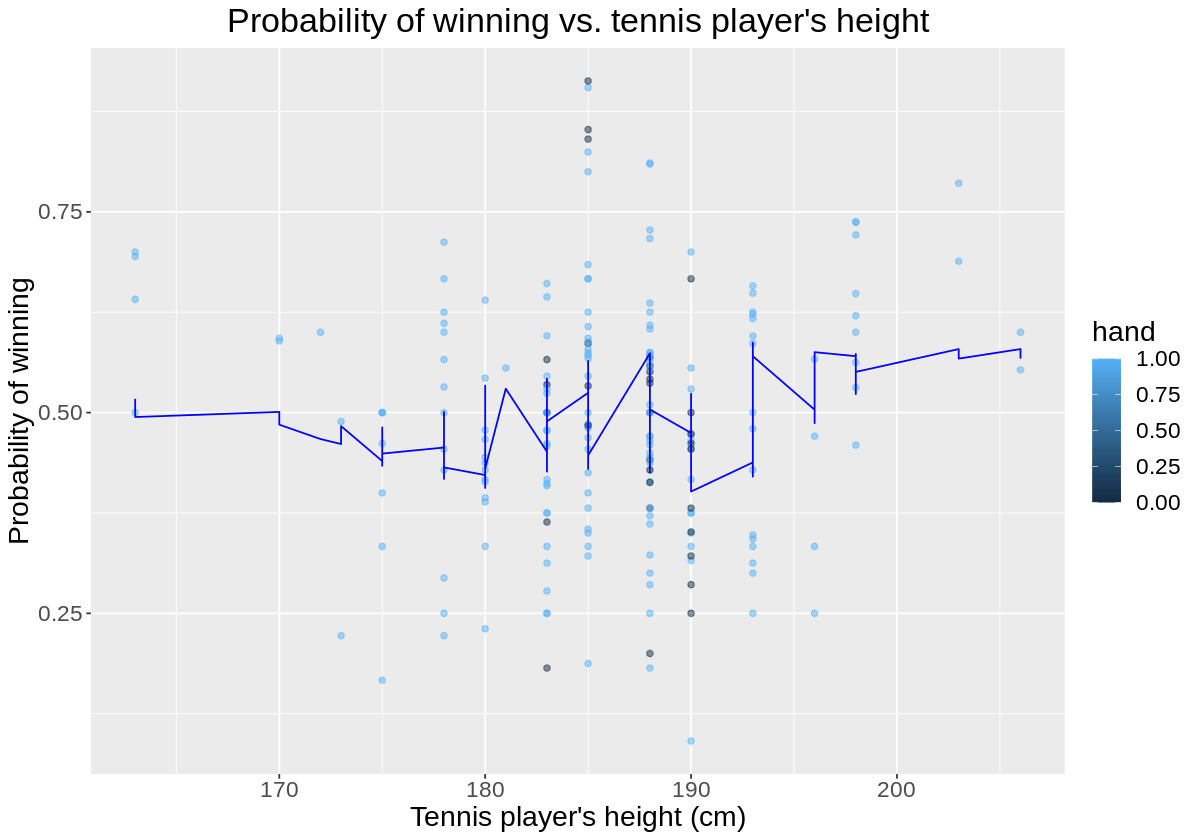

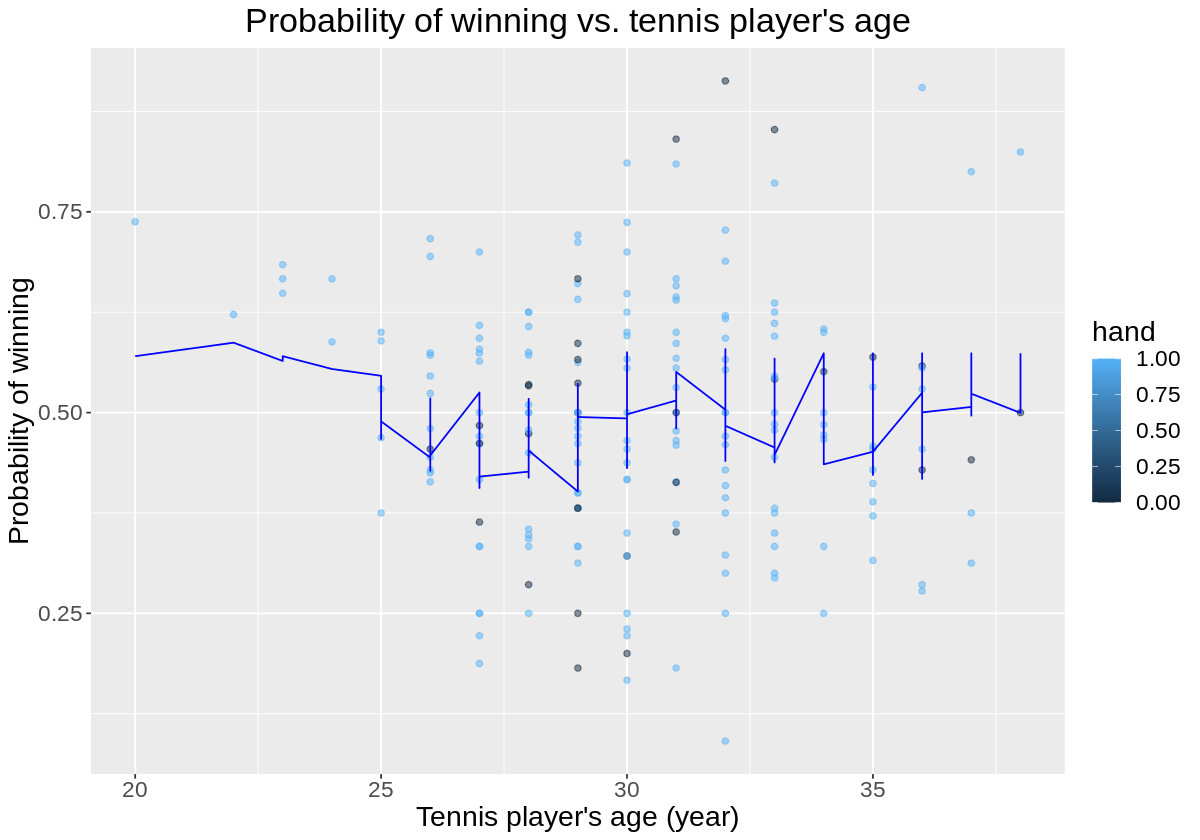

In [91]:
set.seed(2019)

options(repr.plot.width = 10, repr.plot.height = 7)

tennis_preds <- predict(tennis_best_fit, tennis_train) %>%
          bind_cols(tennis_train)

tennis_plot_height <- ggplot(tennis_preds, aes(x = height, y = prob_winning, colour = hand)) +
                        geom_point(alpha = 0.5) +
                        geom_line(data = tennis_preds,
                        mapping = aes(x = height, y = .pred), color = "blue") +
                        xlab("Tennis player's height (cm)") +
                        ylab("Probability of winning") + 
                        ggtitle("Probability of winning vs. tennis player's height") + 
                        theme(text = element_text(size = 17),
                               plot.title = element_text(hjust = 0.5))

tennis_plot_age <- ggplot(tennis_preds, aes(x = age, y = prob_winning, colour = hand)) +
                        geom_point(alpha = 0.5) +
                        geom_line(data = tennis_preds,
                        mapping = aes(x = age, y = .pred), color = "blue") +
                        xlab("Tennis player's age (year)") +
                        ylab("Probability of winning") + 
                        ggtitle("Probability of winning vs. tennis player's age") + 
                        theme(text = element_text(size = 17),
                               plot.title = element_text(hjust = 0.5))

tennis_plot_height
tennis_plot_age                

Figure 6 (Top): Plot of the knn regression model's predictions of probability of winning with respect to height<br>
Figure 7 (Bottom): Plot of the knn regression model's predictions of probability of winning with respect to age

#### 2.5.2 Linear Regression
Now we are going to build linear regression to compare with the result using knn regression. To make an accurate comparison, we are going to use the same training and test data. It should not cause problems since we are building totally different models.

First, we create the recipe and model specification for the linear regression using the same predictors in the knn-regression model. Since this is a multi-variable linear regression, the data doesn't need to be scaled and centered.

In [63]:
# Create Recipe; scale and center all predictors
tennis_reg_recipe <- recipe(prob_winning ~ height + age + hand, data = tennis_train)

# Create model specification
tennis_reg_spec <- linear_reg() %>% 
    set_engine("lm") %>% 
    set_mode("regression")

tennis_reg_recipe

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

Now that we have a recipe and model specification, we can create a workflow for the linear regression fit with the training data.

In [64]:
# Fit model with train data
tennis_reg_fit <- workflow() %>% 
                    add_recipe(tennis_reg_recipe) %>% 
                    add_model(tennis_reg_spec) %>% 
                    fit(data = tennis_train)

tennis_reg_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)       height          age         hand  
   0.322707     0.001294    -0.002517     0.005071  


To test how accurate the trained linear regression model is, we have to apply the model on the testing data and look at the RMSPE into order to compare it to the knn-regression model we had earlier. We can also see the coefficients for the linear regression plane above, but we will look at those shortly. 

In [65]:
# Test model with testing set
tennis_reg_results <- tennis_reg_fit %>% 
                        predict(tennis_test) %>% 
                        bind_cols(tennis_test) %>% 
                        metrics(truth = prob_winning, estimate = .pred)
tennis_reg_results

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,0.1492281
rsq,standard,0.1174921
mae,standard,0.1166919


Table 9: Metrics obtained through applying linear regression model on test data

As seen in Table 9, the RMSPE is 0.1492. This means that the linear regression model prediction was roughly 14.9% away from the actual winning probability of any given tennis player on average. This is a worse RMSPE than the knn-regression since it is higher than the knn-regression RMSPE.

To get the equation of the regression plane, we can look above at the regression fit, or we can also just us the pull_workflow_fit function which is used below. Then, we can take the coefficients from the estimate column to form the equation.

In [66]:
# Get the coefficients for the regression plane created by model
tennis_reg_coeffs <- tennis_reg_fit %>% 
                        pull_workflow_fit() %>% 
                        tidy()

tennis_reg_coeffs

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.322706910,0.295436795,1.0923044,0.2760133
height,0.001294312,0.001531441,0.8451595,0.3990317
age,-0.002516932,0.003243717,-0.7759407,0.4387006
hand,0.005070777,0.029370273,0.1726500,0.8631012


Table 10: Coefficients and their corresponding error values from the linear regression model

Extracting the coefficients for the plane of best fit, we get the following equation:
    
    prob_winning = 0.3227 + 0.0013 * (height) - 0.0025 * (age) + 0.0051 * (hand)
    
Looking at the equation, taller tennis players have a positive relationship with the probability of them winning which means that taller tennis players have a higher chance of winning any given tennis match. Age on the other hand has a negative relationship with the probability of a tennis player winning since the coefficient is negative. This tells us that an older tennis player would have a lower chance of winning a tennis match on average.

Hand also has a positive relationship with the probability of winning. However, since the variable hand is a categorical variable used in the linear regression model, having it in the regression equation doesn't make complete sense because the only values it attains is either 0 or 1. Consequently, having a left handed tennis player would make the contribution of the hand variable 0 since it would cancel out. Having a right handed player would only add 0.5% to the overall probability which is also almost negligible.

## 3.0 Discussion
Tennis is a sport based on unpredictability. The unpredictability of point length, shot selection, strategy, match duration, weather, and the opponent all influence the complex physiological aspects of tennis play (Kovacs, 2006), thus also impacting the probability of a player winning that specific match. Designing and implementing training for tennis requires a solid understanding of the many physiological variables critical to optimal performance, and therefore, this project focuses on determining whether there is a relationship between the physique of tennis players and their probability of winning, studying one aspect that can be applied during physical training of tennis players. 
  
In order to inspect this relationship, we downloaded data from the web, which contained detailed information about matches played during a tournament, and modified the data in a way where we had the physical data for the winner and loser separately from every match. Then, in order to calculate the probability of winning, we bound the data calculated from losers and winners. In order to make our data more unified, we filtered out players who played less than 8 games, since initially, we found that there were too many players that played only one or two games in the tournament, the results were lost in 0 probability of winning. 
  
After summarizing the data, visualizing it and using regression analyses, our findings were as follows. For the initial visualization of winning games against the winner’s main hand, we used a bar plot and found that amongst the winners, a majority of them used their right hand as the main hand. This was not what we expected to find since the literature review showed that left-handed players have a greater advantage in one-on-one sports like tennis. Breznik (2013) quotes Monica Seleš, the former women’s world number one tennis player:
  
*“It’s strange to play a lefty (most players are right-handed) because everything is opposite, and it takes a while to get used to the switch. By the time I feel comfortable, the match is usually over.”*
  
Furthermore, Fagan, Haugh, & Cooper (2018), in their statistical analysis, summarised their results and stated that right-handed players have less familiarity competing against left-handed players (because of the much smaller percentage of lefties in the population) and therefore perform relatively poorly against them as a result. From the review of this study, we reached a consensus that since our data to comprises a majority of right-handed players than left-handed players, it was not possible to compare the performances equally since the dataset’s population was not equally divided, and a biased result was inevitable.
  
Moreover, in order to interpret the relationship between the probability of winning and the tennis player’s height and the relationship between age and probability of winning. The linear regression analysis was discarded since it came out to be more erroneous, and since visualizing it was out of the scope of our knowledge, we decided to stick to the knn-regression analysis. For the analysis of height against the probability of winning, we saw a fluctuating trend and did not get a clear correlational relationship. From a literature standpoint, these findings were what we had expected since, as mentioned by Söğüt (2019), tallest players will demonstrate higher performance in serve variables and shortest players will show better scores in return-related outcomes, demonstrating a varying relationship, with more concentrated winning probability in the average height range. Further, a similar case was seen in the analysis when a tennis player’s age was analyzed against the probability of winning. A fluctuating trend was obtained, which can be explained due to the level of expertise and physical ability. While younger players would be at an added advantage of better physical performance, older players would be at an advantage due to their expertise and experience. Thus, the winning probability would be more concentrated on the average values. 
  
Therefore, these findings can be implemented by introducing training procedures that optimize the performance of players, taking advantage of their age, height, and handedness - variables that cannot be controlled since they are innate. These findings can help in understanding the relationship between the variables and how they add to a player’s probability of winning, enabling them to implement training strategies that help them unlock their full potential. 
  
Future studies can focus on the variables that **can** be controlled, like speed, foot-work, and the frequency of using other strategies like aces and volleys, and analyzed against the winning probability. Therefore, this analysis can help coaches and players implement the findings in their training strategies, further optimizing the player’s performance.
  

## 4.0 References
1.	Breznik, K. (2013). On the Gender Effects of Handedness in Professional Tennis. *Journal Of Sports Science & Medicine*, 12(2), 346. Retrieved from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3761843/

2.	Fagan, F., Haugh, M., & Cooper, H. (2018). The advantage of lefties in one-on-one sports. *Journal of Quantitative Analysis in Sports*, 15(1), 1-25. doi:10.1515/jqas-2017-0076

3.	Kovacs, M. S. (2006). Applied Physiology of Tennis Performance * Commentary. *British Journal of Sports Medicine*, 40(5), 381-386. doi:10.1136/bjsm.2005.023309

4.	Söğüt, M. (2019). Height- and surface-related variations in match-play outcomes and rankings in professional men’s tennis. *German Journal of Exercise and Sport Research*, 49(3), 332-338. doi:10.1007/s12662-019-00612-2
